# MTA vs COVID plot

___

# MTA data

## Read .db data with SQLAlchemy

In [360]:
from sqlalchemy import create_engine

In [361]:
engine = create_engine("sqlite:///mta_data_2015.db")

In [362]:
engine.table_names()

['mta_data']

In [363]:
import pandas as pd

In [364]:
mta_data = pd.read_sql('SELECT * FROM mta_data;', engine)

In [365]:
mta_data.shape

(10028878, 11)

## Cleaning data
From MVP.ipynb

In [366]:
import datetime

In [367]:
mta_data["DATE_TIME"] = pd.to_datetime(mta_data.DATE + " " + mta_data.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [368]:
#only select data from year 2019, and from 12/31/2018 for calculating daily entry gain
#mta_data=mta_data[(mta_data['DATE_TIME'].dt.year == 2019) | (mta_data['DATE']=='12/31/2018')]

In [369]:
mta_data['MONTH']=mta_data['DATE_TIME'].dt.month

In [370]:
mta_data.dtypes

C/A                  object
UNIT                 object
SCP                  object
STATION              object
LINENAME             object
DIVISION             object
DATE                 object
TIME                 object
DESC                 object
ENTRIES               int64
EXITS                 int64
DATE_TIME    datetime64[ns]
MONTH                 int64
dtype: object

In [371]:
# Get rid of the duplicate entry
mta_data.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
mta_data.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [372]:
mta_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,MONTH
193545,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/25/2015,20:00:00,REGULAR,5554,230,2015-12-25 20:00:00,12
193544,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/25/2015,16:00:00,REGULAR,5554,230,2015-12-25 16:00:00,12
193543,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/25/2015,12:00:00,REGULAR,5554,230,2015-12-25 12:00:00,12
193542,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/25/2015,08:00:00,REGULAR,5554,230,2015-12-25 08:00:00,12
193541,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/25/2015,04:00:00,REGULAR,5554,230,2015-12-25 04:00:00,12


In [373]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(mta_data
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,LEXINGTON AVE,2014-12-27 03:00:00,1
6685875,R148,R033,01-03-01,42 ST-TIMES SQ,2015-09-25 20:00:00,1
6685868,R148,R033,01-03-01,42 ST-TIMES SQ,2015-09-24 16:00:00,1
6685869,R148,R033,01-03-01,42 ST-TIMES SQ,2015-09-24 20:00:00,1
6685870,R148,R033,01-03-01,42 ST-TIMES SQ,2015-09-25 00:00:00,1


In [374]:
mta_data = mta_data.drop(["EXITS", "DESC"], axis=1, errors="ignore")

### Match daily max entry with previous day max entry for calculating daily gain

In [375]:
#get daily maximum entries at each turnstile
#groupby automatically sorts grouped columns in ascending order
#since "TIME" is not sorted, it is still in descending order as previously sorted. first() returns the first row of each group
mta_data_daily = (mta_data
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [376]:
mta_data_daily['DATE'] = pd.to_datetime(mta_data_daily['DATE'])

In [377]:
mta_data_daily=mta_data_daily.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE"], ascending=True)

In [378]:
#finding daily gain in entries
mta_data_daily[["PREV_DATE", "PREV_ENTRIES"]] = (mta_data_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))

<ipython-input-378-de1ca14dae5e>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_data_daily[["PREV_DATE", "PREV_ENTRIES"]] = (mta_data_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


In [379]:
#mta_data_daily.DATE.value_counts()

In [380]:
# Drop the rows for the earliest date in the df
mta_data_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

#### Cleaning dirty entries

In [381]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 100,000, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
mta_data_daily["DAILY_ENTRIES"] = mta_data_daily.apply(get_daily_counts, axis=1, max_counter=100000)

In [382]:
#mta_data_daily[(mta_data_daily.DATE=='2020-05-01')&(mta_data_daily.STATION=='137 ST CITY COL')].head(50)

In [383]:
#getting daily entries for making daily heatmap later
total_daily=mta_data_daily.groupby(["DATE"]).DAILY_ENTRIES.sum().reset_index(name ='DAILY_ENTRIES')

In [384]:
total_daily.head()

,DATE,DAILY_ENTRIES
0,2014-12-28,2814375.0
1,2014-12-29,5103288.0
2,2014-12-30,5296417.0
3,2014-12-31,4796475.0
4,2015-01-01,2731483.0


In [385]:
total_daily.to_csv('mta_2015_daily.csv', sep='\t',index=False)

In [386]:
total_daily.head()

,DATE,DAILY_ENTRIES
0,2014-12-28,2814375.0
1,2014-12-29,5103288.0
2,2014-12-30,5296417.0
3,2014-12-31,4796475.0
4,2015-01-01,2731483.0


In [387]:
import seaborn as sns

<AxesSubplot:xlabel='DATE', ylabel='DAILY_ENTRIES'>

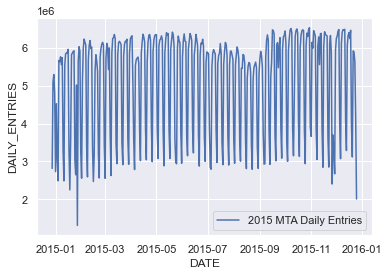

In [388]:
#sanity check
sns.lineplot(data=total_daily,
             x = 'DATE',
             y = 'DAILY_ENTRIES',
             label = '2015 MTA Daily Entries',
            )

### Sum turnstile entries of each station

In [32]:
station_daily = mta_data_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2021-12-26,3041.0
1,1 AV,2021-12-27,5120.0
2,1 AV,2021-12-28,5647.0
3,1 AV,2021-12-29,5821.0
4,1 AV,2021-12-30,5782.0


In [33]:
station_daily["MONTH"] = pd.to_datetime(station_daily['DATE']).dt.strftime('%Y-%m')

In [34]:
station_daily

,STATION,DATE,DAILY_ENTRIES,MONTH
0,1 AV,2021-12-26,3041.0,2021-12
1,1 AV,2021-12-27,5120.0,2021-12
2,1 AV,2021-12-28,5647.0,2021-12
3,1 AV,2021-12-29,5821.0,2021-12
4,1 AV,2021-12-30,5782.0,2021-12
...,...,...,...,...
7534,ZEREGA AV,2022-01-10,1078.0,2022-01
7535,ZEREGA AV,2022-01-11,1158.0,2022-01
7536,ZEREGA AV,2022-01-12,1257.0,2022-01
7537,ZEREGA AV,2022-01-13,1188.0,2022-01


In [35]:
station_monthly=station_daily.groupby(["STATION", "MONTH"]).DAILY_ENTRIES.sum().reset_index(name ='MONTHLY_ENTRIES')

In [36]:
total_monthly=station_daily.groupby(["MONTH"]).DAILY_ENTRIES.sum().reset_index(name ='MONTHLY_ENTRIES')

In [37]:
total_monthly

,MONTH,MONTHLY_ENTRIES
0,2021-12,9665471.0
1,2022-01,23642866.0


In [38]:
#write 2019's monthly MTA data to .csv
total_monthly.to_csv('mta_2018_monthly.csv', sep='\t', index=True)

___

# NYC COVID data
data from https://github.com/nytimes/covid-19-data

In [51]:
from matplotlib import pyplot as plt
import seaborn as sns

In [52]:
COVID_data=pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [53]:
NYC_COVID_Data=COVID_data[COVID_data.county=='New York City']

In [54]:
NYC_COVID_Data

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0.0
448,2020-03-02,New York City,New York,NaN,1,0.0
482,2020-03-03,New York City,New York,NaN,2,0.0
518,2020-03-04,New York City,New York,NaN,2,0.0
565,2020-03-05,New York City,New York,NaN,4,0.0
...,...,...,...,...,...,...
2124012,2022-01-17,New York City,New York,NaN,2123721,36698.0
2127264,2022-01-18,New York City,New York,NaN,2134609,36949.0
2130518,2022-01-19,New York City,New York,NaN,2145910,37122.0
2133770,2022-01-20,New York City,New York,NaN,2159384,37228.0


In [55]:
NYC_COVID_Data[['previous_date','previous_cases']]=NYC_COVID_Data[['date','cases']].shift(1)
#mta_data_daily[["PREV_DATE", "PREV_ENTRIES"]] = (mta_data.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))

C:\Users\Josh_Wang\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [62]:
NYC_COVID_Data

,date,cases,previous_date,previous_cases
416,2020-03-01,1,NaN,NaN
448,2020-03-02,1,2020-03-01,1.0
482,2020-03-03,2,2020-03-02,1.0
518,2020-03-04,2,2020-03-03,2.0
565,2020-03-05,4,2020-03-04,2.0
...,...,...,...,...
2124012,2022-01-17,2123721,2022-01-16,2109910.0
2127264,2022-01-18,2134609,2022-01-17,2123721.0
2130518,2022-01-19,2145910,2022-01-18,2134609.0
2133770,2022-01-20,2159384,2022-01-19,2145910.0


In [57]:
#subsetting df
NYC_COVID_Data=NYC_COVID_Data[['date','cases','previous_date','previous_cases']]

In [63]:
#checking presence of NaN
NYC_COVID_Data.isna().any(axis=1)

416         True
448        False
482        False
518        False
565        False
           ...  
2124012    False
2127264    False
2130518    False
2133770    False
2137024    False
Length: 692, dtype: bool

In [64]:
#replace NaN with zero
NYC_COVID_Data.fillna(0)

,date,cases,previous_date,previous_cases
416,2020-03-01,1,0,0.0
448,2020-03-02,1,2020-03-01,1.0
482,2020-03-03,2,2020-03-02,1.0
518,2020-03-04,2,2020-03-03,2.0
565,2020-03-05,4,2020-03-04,2.0
...,...,...,...,...
2124012,2022-01-17,2123721,2022-01-16,2109910.0
2127264,2022-01-18,2134609,2022-01-17,2123721.0
2130518,2022-01-19,2145910,2022-01-18,2134609.0
2133770,2022-01-20,2159384,2022-01-19,2145910.0


In [65]:
NYC_COVID_Data['daily_cases']=NYC_COVID_Data.cases-NYC_COVID_Data.previous_cases

<ipython-input-65-8811400d892b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYC_COVID_Data['daily_cases']=NYC_COVID_Data.cases-NYC_COVID_Data.previous_cases


In [66]:
NYC_COVID_Data['date'] = pd.to_datetime(NYC_COVID_Data['date'])

<ipython-input-66-d57b54f53e8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYC_COVID_Data['date'] = pd.to_datetime(NYC_COVID_Data['date'])


In [67]:
NYC_COVID_Data['abbrev_date']=NYC_COVID_Data['date'].dt.month_name().str[:3]+' '+NYC_COVID_Data['date'].dt.day.astype(str)

<ipython-input-67-ffd739536c36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYC_COVID_Data['abbrev_date']=NYC_COVID_Data['date'].dt.month_name().str[:3]+' '+NYC_COVID_Data['date'].dt.day.astype(str)


In [68]:
NYC_COVID_Data['rolling_daily_cases']=NYC_COVID_Data.daily_cases.rolling(7).mean()

<ipython-input-68-34808aa0b23a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYC_COVID_Data['rolling_daily_cases']=NYC_COVID_Data.daily_cases.rolling(7).mean()


In [69]:
NYC_COVID_Data.head()

,date,cases,previous_date,previous_cases,daily_cases,abbrev_date,rolling_daily_cases
416,2020-03-01,1,NaN,NaN,NaN,Mar 1,NaN
448,2020-03-02,1,2020-03-01,1.0,0.0,Mar 2,NaN
482,2020-03-03,2,2020-03-02,1.0,1.0,Mar 3,NaN
518,2020-03-04,2,2020-03-03,2.0,0.0,Mar 4,NaN
565,2020-03-05,4,2020-03-04,2.0,2.0,Mar 5,NaN


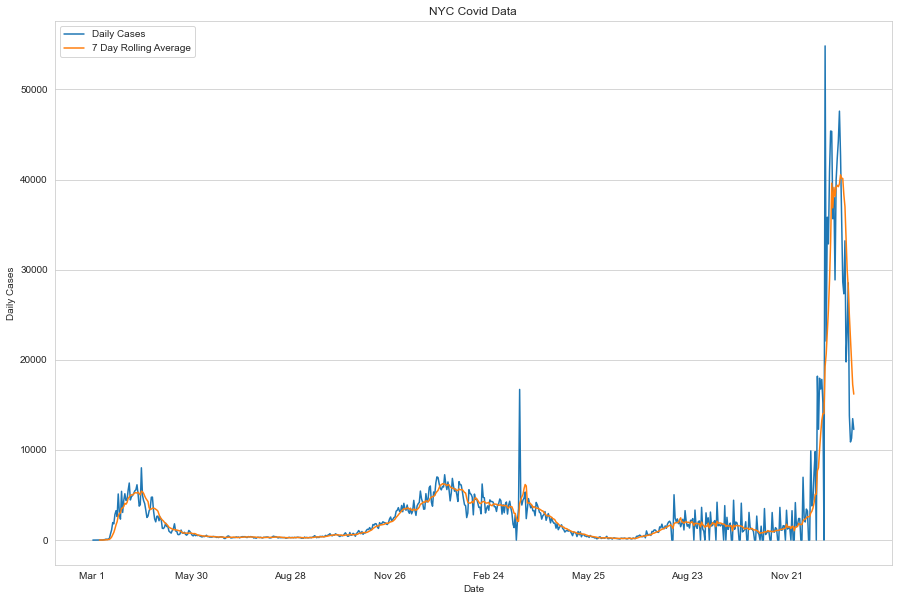

In [70]:
#Plotting NYC covid data
plt.figure( figsize = (15, 10))

sns.set_style("whitegrid")
fig1=sns.lineplot(data=NYC_COVID_Data, 
                  x='date', 
                  y='daily_cases', 
                 #hue="Base Name",
                 #palette={'LYFT':'tab:pink','UBER':'black'},
                  label = 'Daily Cases'
                 )
sns.lineplot(data=NYC_COVID_Data,
             x = 'date',
             y = 'rolling_daily_cases',
             label = '7 Day Rolling Average')

fig1.xaxis.grid(False)
xticks=NYC_COVID_Data.date[::90] #only show tick for every 90 days
xlabels=NYC_COVID_Data.abbrev_date[::90] #only show tick for every 90 days
plt.xticks(xticks,xlabels,rotation=0) #only show tick for every 90 days
plt.xlabel("Date"
           #, fontsize = 20
          )
plt.ylabel("Daily Cases"
           #, fontsize = 20
          )
#plt.tight_layout()
#plt.legend(fontsize = 20)
plt.title("NYC Covid Data"
          #, fontsize = 30
         )
#fig.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
sns.set(font_scale = 2)

#fig1.figure.savefig("MVP_covid.png")

## Overlaying COVID data with MAT data

In [39]:
def get_mta_data(week_nums):
    filepath = "mta_{}_daily.csv"
    dfs = []
    for year in years:
        file = filepath.format(year)
        dfs.append(pd.read_csv(file, sep='\t'))
    return pd.concat(dfs)
        
years=[2019,2020,2021,2022]
mta_df = get_mta_data(years)

In [40]:
mta_df

,DATE,DAILY_ENTRIES
0,2018-11-25,2456163.0
1,2018-11-26,5801635.0
2,2018-11-27,6163944.0
3,2018-11-28,6242837.0
4,2018-11-29,6330155.0
...,...,...
15,2022-01-10,1977437.0
16,2022-01-11,1851748.0
17,2022-01-12,2158086.0
18,2022-01-13,2114752.0


In [41]:
mta_df[mta_df.isna().any(axis=1)]

,DATE,DAILY_ENTRIES


In [42]:
mta_df.drop_duplicates(subset=["DATE"], inplace=True)

In [43]:
mta_df

,DATE,DAILY_ENTRIES
0,2018-11-25,2456163.0
1,2018-11-26,5801635.0
2,2018-11-27,6163944.0
3,2018-11-28,6242837.0
4,2018-11-29,6330155.0
...,...,...
15,2022-01-10,1977437.0
16,2022-01-11,1851748.0
17,2022-01-12,2158086.0
18,2022-01-13,2114752.0


In [44]:
mta_df['DATE']=pd.to_datetime(mta_df['DATE'])

In [135]:
mta_df['date_as_string']=mta_df['DATE'].astype(str)

In [193]:
mta_df['rolling_daily_entries']=mta_df.DAILY_ENTRIES.rolling(7).mean()

In [194]:
mta_df=mta_df.reset_index()

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

<ipython-input-391-1c73ce1fd074>:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 13)
<ipython-input-391-1c73ce1fd074>:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), size = 13)


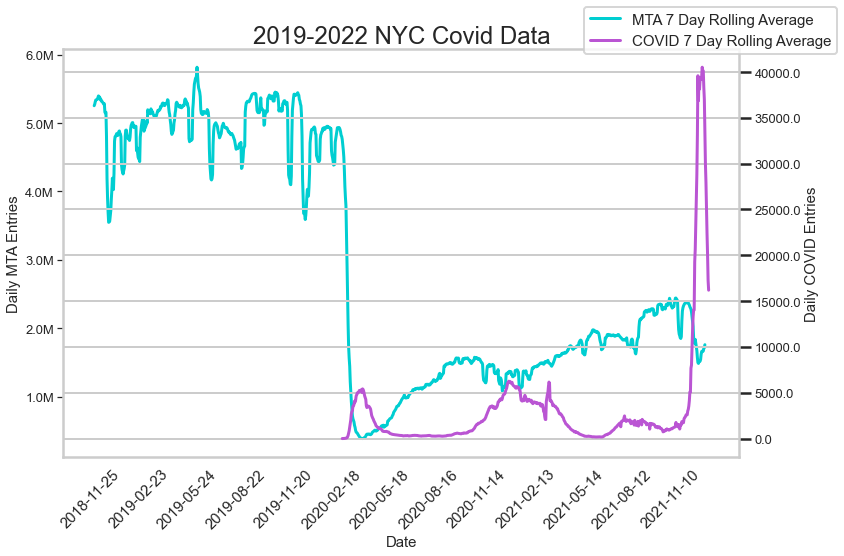

In [391]:
#Plotting NYC covid overlayed with MTA data
#plt.figure( figsize = (10, 10))

#https://learndataanalysis.org/source-code-format-axis-label-to-thousands-and-millions-suffix-matplotlib-tutorial/
#https://stackoverflow.com/questions/61330427/set-y-axis-in-millions
#Format Axis Label To Thousands and Millions Suffix
def millions_formatter(x, pos):
    return f'{x / 1000000}M'


fig, ax = plt.subplots(figsize=(12,8))


xticks=mta_df.DATE[::90]
xlabels=mta_df['date_as_string'][::90]

ax.set_facecolor('white')
sns.set_style("whitegrid")
sns.set_context("poster")
sns.despine()

ax=sns.lineplot(data=mta_df,
                x = 'DATE',
                y = 'rolling_daily_entries',
                label = 'MTA 7 Day Rolling Average',
                legend=False,
                color='darkturquoise'
               )
                
ax2 = ax.twinx()
                
sns.lineplot(data=NYC_COVID_Data,
             x = 'date',
             y = 'rolling_daily_cases',
             label = 'COVID 7 Day Rolling Average',
             ax=ax2,
             color="mediumorchid",
             legend=False
             )

ax.yaxis.grid(False)
#ax2.yaxis.grid(False)
ax.xaxis.grid(False)
#ax2.xaxis.grid(False)

#xticks=NYC_COVID_Data.date[::90] #only show tick for every 90 days
#xlabels=NYC_COVID_Data.abbrev_date[::90] #only show tick for every 90 days

#ax.set_xticklabels(labels=xlabels, rotation=30)

#plt.xlabel("aergaerg"
           #, fontsize = 20
          #)

#plt.ylabel("Daily Cases"
           #, fontsize = 20
          #)

ax.set_ylabel('Daily MTA Entries', fontsize = 15)
ax2.set_ylabel('Daily COVID Entries', fontsize = 15)
ax.set_xlabel('Date', fontsize = 15)


#plt.tight_layout()
#plt.legend(fontsize = 20)

plt.title("2019-2022 NYC Covid Data"
          #, fontsize = 30
         )

fig.legend(fontsize = 15)

ax.xaxis.set_ticks(xticks)
ax.xaxis.set_ticklabels(xlabels, rotation=45, fontsize = 15)

ax.set_yticklabels(ax.get_yticks(), size = 13)
ax2.set_yticklabels(ax2.get_yticks(), size = 13)
#ax.set_xticklabels(ax2.get_xticklabels(), rotation=45)

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

fig.tight_layout()
sns.set(font_scale = 1)

fig.figure.savefig("COVID_MTA.png", dpi=1200, transparent=True)